# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [139]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Research-grade GNN-LSTM pipeline for multi-asset market modeling.
Predicts direction of price for Asset ETH using multi-window attention over correlations.

Structure:
1) Synthetic data generation (3k rows, 5m intervals)
2) Preprocessing, cleaning, winsorization, normalization
3) Rolling correlations with multiple windows (5 windows)
4) Dataset + DataLoader + collate_fn
5) GNN (GCN-style) + LSTM temporal aggregator + classifier
6) Train/Val/Test split 50-20-30
7) Training loop with accuracy, loss tracking
8) Monitoring attention + avg adjacency
9) Visualization for train and for test
"""

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import pandas as pd
from pathlib import Path

In [140]:

# ============================================================
# 1. Load data
# ============================================================


def load_asset(asset):
    freq = '5min'
    DATA_DIR = Path('../dataset')
    path = DATA_DIR / f"{asset}_{freq}.csv"

    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df["system_time"])
    df['timestamp'] = df['timestamp'].dt.round('min')
    df = df.sort_values('timestamp').set_index('timestamp')
    return df[['midpoint','bids_notional_0', 'asks_notional_0', 'bids_distance_0', 'asks_distance_0', 'spread', 'buys', 'sells']]  
    
df_ADA = load_asset("ADA").rename(columns={'midpoint': 'ADA', 'buys': 'buys_ADA', 'sells': 'sells_ADA', 'bids_notional_0': 'bids_vol_ADA', 'asks_notional_0': 'asks_vol_ADA', 'bids_distance_0': 'bids_dist_ADA', 'asks_distance_0': 'asks_dist_ADA', 'spread': 'spread_ADA', })
df_BTC = load_asset("BTC").rename(columns={'midpoint': 'BTC', 'buys': 'buys_BTC', 'sells': 'sells_BTC', 'bids_notional_0': 'bids_vol_BTC', 'asks_notional_0': 'asks_vol_BTC', 'bids_distance_0': 'bids_dist_BTC', 'asks_distance_0': 'asks_dist_BTC', 'spread': 'spread_BTC', })
df_ETH = load_asset("ETH").rename(columns={'midpoint': 'ETH', 'buys': 'buys_ETH', 'sells': 'sells_ETH', 'bids_notional_0': 'bids_vol_ETH', 'asks_notional_0': 'asks_vol_ETH', 'bids_distance_0': 'bids_dist_ETH', 'asks_distance_0': 'asks_dist_ETH', 'spread': 'spread_ETH', })
df = df_ADA.join(df_BTC).join(df_ETH)

df.reset_index(inplace=True)

T = len(df)

# log returns & target
df["lr_ADA"] = np.log(df["ADA"]).diff().fillna(0)
df["lr_BTC"] = np.log(df["BTC"]).diff().fillna(0)
df["lr_ETH"] = np.log(df["ETH"]).diff().fillna(0)
#df["target"] = (df["ADA"].shift(-1) > df["ADA"]).astype(int) next-step direction of Asset ETH --- 50%
#df["target"] = (df["lr_ETH"].shift(-6).abs() > 0.003).astype(int)  # significant move in next 30min --- 70%-80%
#df["target"] = ((df["lr_ETH"].shift(-6) > 0) & (df["lr_ETH"].shift(-6).abs() > 0.001)).astype(int)  # direction of significant move in next 30min --- 60%-70%
df["target"] = (df["ETH"].shift(-6) > df["ETH"]).astype(int)    # direction in next 30min --- 50%

#df["fwd_lr_12"] = df["lr_ETH"].rolling(12).sum().shift(-12)
#df["target"] = (df["fwd_lr_12"] > 0).astype(int) # cumulative log return of 1h move --- 50%-54%

#df["target"] = (((df["lr_ETH"].shift(-6) > 0)-0.5)*2 * (df["lr_ETH"].shift(-6).abs() > 0.002)).astype(int)+1  # direction of significant move in next 30min --- 62% against 79% baseline


In [141]:
COLUMNS = ["ADA",
            "buys_ADA", 
            "sells_ADA",
            "bids_vol_ADA",
            "asks_vol_ADA",
            "bids_dist_ADA", 
            "asks_dist_ADA", 
            "spread_ADA", 
            "lr_ADA", 
            # ---
            "BTC",
            "buys_BTC", 
            "sells_BTC",
            "bids_vol_BTC",
            "asks_vol_BTC",
            "bids_dist_BTC", 
            "asks_dist_BTC",
            "spread_BTC",
            "lr_BTC",
            # ---
            "ETH",
            "buys_ETH", 
            "sells_ETH",
            "bids_vol_ETH",
            "asks_vol_ETH",
            "bids_dist_ETH", 
            "asks_dist_ETH",
            "spread_ETH",
            "lr_ETH"]


df.target.value_counts(normalize=True)


target
1    0.532522
0    0.467478
Name: proportion, dtype: float64

In [142]:

# ============================================================
# 2. Full cleaning pipeline
# ============================================================

for col in ["buys_ADA", "buys_BTC", "buys_ETH",
            "sells_ADA", "sells_BTC", "sells_ETH",
            "bids_vol_ADA", "bids_vol_BTC", "bids_vol_ETH",
            "asks_vol_ADA", "asks_vol_BTC", "asks_vol_ETH"]:
    df[col] = df[col].clip(lower=1e-6)

def winsorize(series, q=0.995):
    low = series.quantile(1-q)
    high = series.quantile(q)
    return series.clip(lower=low, upper=high)

for col in ["buys_ADA", "buys_BTC", "buys_ETH",
            "sells_ADA", "sells_BTC", "sells_ETH",
            "bids_vol_ADA", "bids_vol_BTC", "bids_vol_ETH",
            "asks_vol_ADA", "asks_vol_BTC", "asks_vol_ETH"]:
    df[col] = winsorize(df[col])

#df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df.ffill(inplace=True)
#df.bfill(inplace=True)

for col in ["ADA", "BTC", "ETH"]:
    df[col] = df[col].clip(lower=1e-8)

for col in ["lr_ADA", "lr_BTC", "lr_ETH"]:
    df[col] = df[col].clip(lower=-0.2, upper=0.2)

print("\nSanitized Data Summary:\n", df.describe())



Sanitized Data Summary:
                ADA  bids_vol_ADA   asks_vol_ADA  bids_dist_ADA  asks_dist_ADA  \
count  3367.000000   3367.000000    3367.000000    3367.000000    3367.000000   
mean      1.315086   6653.414656    7457.980906      -0.000255       0.000255   
std       0.102222  10142.149344   17320.947592       0.000257       0.000257   
min       1.136350      1.220000       6.063400      -0.005536       0.000033   
25%       1.214750   2026.534973    1165.170044      -0.000306       0.000140   
50%       1.299500   3189.639893    2870.780029      -0.000211       0.000211   
75%       1.415900   5507.334961    6787.079834      -0.000140       0.000306   
max       1.557050  77046.272500  186063.859688      -0.000033       0.005536   

        spread_ADA      buys_ADA     sells_ADA           BTC   bids_vol_BTC  \
count  3367.000000  3.367000e+03  3.367000e+03   3365.000000    3365.000000   
mean      0.000672  2.213041e+05  1.810783e+05  59973.912582   74033.060271   
std    

In [143]:

# ============================================================
# 3. Multi-window correlations
# ============================================================

candidate_windows = [6, 12, 24, 48, 96]   # 30m, 1h, 2h, 4h, 8h
n_w = len(candidate_windows)

edges = [("ADA","BTC"), ("ADA","ETH"), ("ETH","BTC")]
n_edges = len(edges)

corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

for wi, w in enumerate(candidate_windows):
    r_ADA_BTC = df["lr_ADA"].rolling(w, min_periods=1).corr(df["lr_BTC"])
    r_ADA_ETH = df["lr_ADA"].rolling(w, min_periods=1).corr(df["lr_ETH"])
    r_ETH_BTC = df["lr_ETH"].rolling(w, min_periods=1).corr(df["lr_BTC"])

    corr_array[:,0,wi] = np.nan_to_num(r_ADA_BTC)
    corr_array[:,1,wi] = np.nan_to_num(r_ADA_ETH)
    corr_array[:,2,wi] = np.nan_to_num(r_ETH_BTC)

print("corr_array shape:", corr_array.shape)


corr_array shape: (3367, 3, 5)


In [144]:
# ============================================================
# 4. Train/Val/Test split 70–15–15
# ============================================================

total_len = len(df)
train_end = int(total_len * 0.70)
val_end   = int(total_len * 0.85)

df_train = df.iloc[:train_end].reset_index(drop=True)
df_val   = df.iloc[train_end:val_end].reset_index(drop=True)
df_test  = df.iloc[val_end:].reset_index(drop=True)

corr_train = corr_array[:train_end]
corr_val   = corr_array[train_end:val_end]
corr_test  = corr_array[val_end:]

# ============================================================
# 4.1 Compute normalization stats ONLY on train
# ============================================================

#mean = df_train[COLUMNS].mean().values  
#std  = df_train[COLUMNS].std().values + 1e-8  

ADA_cols = [
"ADA", "buys_ADA", "sells_ADA",
"bids_vol_ADA", "asks_vol_ADA",
"bids_dist_ADA", "asks_dist_ADA",
"spread_ADA", "lr_ADA"
]

BTC_cols = [
"BTC", "buys_BTC", "sells_BTC",
"bids_vol_BTC", "asks_vol_BTC",
"bids_dist_BTC", "asks_dist_BTC",
"spread_BTC", "lr_BTC"
]

ETH_cols = [
"ETH", "buys_ETH", "sells_ETH",
"bids_vol_ETH", "asks_vol_ETH",
"bids_dist_ETH", "asks_dist_ETH",
"spread_ETH", "lr_ETH"
]

#  mean/std per node

mean_ADA = df_train[ADA_cols].mean().values
std_ADA = df_train[ADA_cols].std().values + 1e-8

mean_BTC = df_train[BTC_cols].mean().values
std_BTC = df_train[BTC_cols].std().values + 1e-8

mean_ETH = df_train[ETH_cols].mean().values
std_ETH = df_train[ETH_cols].std().values + 1e-8

print(f"\nNormalization stats (from TRAIN only): shape {mean_ADA.shape} ")
print("Train mean ADA:", mean_ADA)
print("Train std ADA: ", std_ADA)

print(f"\nNormalization stats (from TRAIN only): shape {mean_BTC.shape} ")
print("Train mean BTC:", mean_BTC)
print("Train std BTC: ", std_BTC)

print(f"\nNormalization stats (from TRAIN only): shape {mean_ETH.shape} ")
print("Train mean ETH:", mean_ETH)
print("Train std ETH: ", std_ETH)


Normalization stats (from TRAIN only): shape (9,) 
Train mean ADA: [ 1.29467216e+00  2.00270290e+05  1.58754288e+05  6.41537938e+03
  7.14619346e+03 -2.13974802e-04  2.13974802e-04  5.62054329e-04
  9.47165024e-05]
Train std ADA:  [1.02241915e-01 1.93681369e+05 1.87689158e+05 1.01885300e+04
 1.67317222e+04 1.22650177e-04 1.22650177e-04 3.44605925e-04
 3.74006158e-03]

Normalization stats (from TRAIN only): shape (9,) 
Train mean BTC: [ 6.01386364e+04  1.44271501e+06  1.25860926e+06  8.26444155e+04
  8.32921434e+04 -6.99282591e-06  6.99282591e-06  8.50394904e-01
  5.40965097e-05]
Train std BTC:  [2.31142494e+03 1.50449593e+06 1.40038920e+06 1.35258704e+05
 1.26068369e+05 2.07843542e-05 2.07843542e-05 2.53577091e+00
 1.76682697e-03]

Normalization stats (from TRAIN only): shape (9,) 
Train mean ETH: [ 2.17715046e+03  7.68140958e+05  6.25960493e+05  2.96085673e+04
  3.01022948e+04 -2.94548184e-05  2.94548184e-05  1.29197452e-01
  9.85179180e-05]
Train std ETH:  [1.38204926e+02 7.75984049

In [145]:
class MarketDataset(Dataset):
    def __init__(self, df, corr_array, mean_ADA, std_ADA, mean_BTC, std_BTC, mean_ETH, std_ETH, SEQ_LEN=12):
        self.df = df.reset_index(drop=True)
        self.corr = corr_array
        self.mean_ADA = mean_ADA
        self.std_ADA = std_ADA
        self.mean_BTC = mean_BTC
        self.std_BTC = std_BTC
        self.mean_ETH = mean_ETH
        self.std_ETH = std_ETH
        self.SEQ_LEN = SEQ_LEN

    def __len__(self):
        return len(self.df) - self.SEQ_LEN

    def __getitem__(self, idx):
        x_seq = self.df.iloc[idx : idx + self.SEQ_LEN][COLUMNS].values.astype(np.float32)
        corr_seq = self.corr[idx : idx + self.SEQ_LEN].astype(np.float32)

        # reshape into (seq, 3 nodes, 9 features)
        x_seq = x_seq.reshape(self.SEQ_LEN, 3, 9)

        # normalize per node
        x_seq[:, 0, :] = (x_seq[:, 0, :] - self.mean_ADA) / self.std_ADA
        x_seq[:, 1, :] = (x_seq[:, 1, :] - self.mean_BTC) / self.std_BTC
        x_seq[:, 2, :] = (x_seq[:, 2, :] - self.mean_ETH) / self.std_ETH

        target = int(self.df["target"].iloc[idx + self.SEQ_LEN])
        return x_seq, corr_seq, target



# create datasets (pass 6 arrays for normalization)

dataset_train = MarketDataset(df_train, corr_train,
    mean_ADA, std_ADA,
    mean_BTC, std_BTC,
    mean_ETH, std_ETH)

dataset_val = MarketDataset(df_val, corr_val,
    mean_ADA, std_ADA,
    mean_BTC, std_BTC,
    mean_ETH, std_ETH)

dataset_test = MarketDataset(df_test, corr_test,
    mean_ADA, std_ADA,
    mean_BTC, std_BTC,
    mean_ETH, std_ETH)

loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

print("\nDataset sizes:")
print("Train:", len(dataset_train))
print("Val: ", len(dataset_val))
print("Test: ", len(dataset_test))


Dataset sizes:
Train: 2344
Val:  493
Test:  494


In [146]:
# ============================================================
# 4. Dataset + DataLoader 
# ============================================================

class MarketDataset(Dataset):
    def __init__(self, df, corr_array, mean, std, window=12, normalize=True):
        # df and corr_array must already be split (train/val/test)
        self.df = df.reset_index(drop=True)
        self.T = len(df)
        self.window = window
        self.corr_array = corr_array
        self.normalize = normalize

        # mean/std must come from TRAIN ONLY
        self.mean = mean
        self.std  = std

    def __len__(self):
        return self.T - self.window - 1

    def _node_features(self, row, asset):
        return np.array([
            row[f"{asset}"],           # price
            row[f"buys_{asset}"],      # buys
            row[f"sells_{asset}"],     # sells
            row[f"bids_vol_{asset}"],  # bids volume
            row[f"asks_vol_{asset}"],  # asks volume
            row[f"bids_dist_{asset}"], # bid distance
            row[f"asks_dist_{asset}"], # ask distance
            row[f"spread_{asset}"],    # spread
            row[f"lr_{asset}"],        # log return
        ], dtype=np.float32)

    def __getitem__(self, idx):
        x_seq = []

        for t in range(idx, idx+self.window):
            row = self.df.loc[t]

            # --- get raw features per node ---
            ADA_feat = self._node_features(row, "ADA")
            BTC_feat = self._node_features(row, "BTC")
            ETH_feat = self._node_features(row, "ETH")

            # --- normalize per node separately ---
            if self.normalize:
                ADA_feat = (ADA_feat - self.mean[:9]) / self.std[:9]
                BTC_feat = (BTC_feat - self.mean[9:18]) / self.std[9:18]
                ETH_feat = (ETH_feat - self.mean[18:]) / self.std[18:]

            # --- stack nodes ---
            nf = np.stack([ADA_feat, BTC_feat, ETH_feat]).astype(np.float32)
            x_seq.append(torch.tensor(nf, dtype=torch.float32))

        target = int(self.df.loc[idx+self.window].target)
        corr_slice = self.corr_array[idx:idx+self.window,:,:]

        return x_seq, torch.tensor(target, dtype=torch.long), torch.tensor(corr_slice, dtype=torch.float32)



def collate_fn(batch):
    # Proper batching for batch_size=1:
    return batch[0]


In [147]:


# ============================================================
# 5.2 Build datasets
# ============================================================

dataset_train = MarketDataset(df_train, corr_train, mean, std)
dataset_val   = MarketDataset(df_val,   corr_val,   mean, std)
dataset_test  = MarketDataset(df_test,  corr_test,  mean, std)

loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True,  collate_fn=collate_fn)
loader_val   = DataLoader(dataset_val,   batch_size=1, shuffle=False, collate_fn=collate_fn)
loader_test  = DataLoader(dataset_test,  batch_size=1, shuffle=False, collate_fn=collate_fn)

print("\nDataset sizes:")
print("Train:", len(dataset_train))
print("Val:  ", len(dataset_val))
print("Test: ", len(dataset_test))



Dataset sizes:
Train: 2343
Val:   492
Test:  493


## 6. GNN + LSTM model

In [148]:
# ============================================================
# 6. GNN + LSTM model
# ============================================================

class GNN_LSTM(nn.Module):
    def __init__(self, hidden_dim=32, lstm_hidden=32, n_edges=3, n_windows=5):
        super().__init__()
        
        # node_feats=9 -> hidden_dim
        self.fc_node = nn.Linear(9, hidden_dim)

        # attention over edges × windows
        self.attn = nn.Parameter(torch.randn(n_edges, n_windows))

        # temporal aggregation only for node A
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden, batch_first=True)

        self.fc_out = nn.Linear(lstm_hidden, 2)

    def forward(self, x_seq, corr_slice):
        L = len(x_seq)

        # x_seq: list of (3,node_feats)
        # project each node: (L,3,hidden_dim)
        x = torch.stack([self.fc_node(e) for e in x_seq], dim=0)

        # softmax attention over windows
        attn_w = F.softmax(self.attn, dim=-1)  # (3,5)

        # combine correlations with attention weights
        # corr_slice (L,3,5)
        corr_w = torch.einsum("l e w, e w -> l e", corr_slice, attn_w)

        h = x.clone()

        # message passing (GCN-style)
        # Edge order: (ADA,BTC), (ADA,ETH), (ETH,BTC)
        # h[:, node, :]
        h[:,0,:] += corr_w[:,0:1]*x[:,1,:] + corr_w[:,1:2]*x[:,2,:]
        h[:,1,:] += corr_w[:,0:1]*x[:,0,:] + corr_w[:,2:3]*x[:,2,:]
        h[:,2,:] += corr_w[:,1:2]*x[:,0,:] + corr_w[:,2:3]*x[:,1,:]

        a_seq = h[:,0,:].unsqueeze(0)  # (1,L,hid)

        out,_ = self.lstm(a_seq)
        last = out[:, -1, :]

        logits = self.fc_out(last)
        return logits, attn_w, corr_w


model = GNN_LSTM(hidden_dim=32, lstm_hidden=32, n_edges=3, n_windows=n_w)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


## 7. Training loop (Train + Val)

In [149]:

# ============================================================
# 7. Training loop (Train + Val)
# ============================================================

n_epochs = 5
train_loss_hist = []
train_acc_hist = []
val_acc_hist = []
attn_history = []
avg_adj_hist = []

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_seq, target, corr_slice in loader:
            logits, _, _ = model(x_seq, corr_slice)
            pred = logits.argmax(1)
            correct += (pred == target).sum().item()
            total += 1
    return correct/total if total>0 else 0

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    attn_epoch = []
    adj_epoch = []

    for x_seq, target, corr_slice in loader_train:
        optimizer.zero_grad()
        logits, attn_w, corr_w = model(x_seq, corr_slice)
        loss = criterion(logits, target.unsqueeze(0))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == target).sum().item()
        total += 1

        attn_epoch.append(attn_w.detach().numpy())
        adj_epoch.append(corr_w.mean(0).detach().numpy())

    train_loss_hist.append(total_loss/total)
    train_acc_hist.append(correct/total)
    val_acc = evaluate(loader_val)
    val_acc_hist.append(val_acc)

    attn_history.append(np.mean(attn_epoch, axis=0))
    avg_adj_hist.append(np.mean(adj_epoch, axis=0))

    best_window = candidate_windows[np.argmax(attn_history[-1].mean(0))]

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"TrainLoss={train_loss_hist[-1]:.4f} | "
          f"TrainAcc={train_acc_hist[-1]:.4f} | "
          f"ValAcc={val_acc:.4f} | "
          f"BestWindow={best_window}")

attn_history = np.stack(attn_history)
avg_adj_hist = np.stack(avg_adj_hist)


Epoch 1/5 | TrainLoss=nan | TrainAcc=0.4494 | ValAcc=0.5183 | BestWindow=6
Epoch 2/5 | TrainLoss=nan | TrainAcc=0.4499 | ValAcc=0.5183 | BestWindow=6
Epoch 3/5 | TrainLoss=nan | TrainAcc=0.4499 | ValAcc=0.5183 | BestWindow=6
Epoch 4/5 | TrainLoss=nan | TrainAcc=0.4499 | ValAcc=0.5183 | BestWindow=6
Epoch 5/5 | TrainLoss=nan | TrainAcc=0.4499 | ValAcc=0.5183 | BestWindow=6


## 8. Test evaluation

In [150]:

# ============================================================
# 8. Test evaluation
# ============================================================

test_acc = evaluate(loader_test)
print("\n==========================")
print("FINAL TEST ACCURACY:", test_acc)
print("==========================\n")



FINAL TEST ACCURACY: 0.4969574036511156



In [151]:
predictions = []
model.eval()
with torch.no_grad():
    for x_seq, target, corr_slice in loader_test:
        logits, attn_w, corr_w = model(x_seq, corr_slice)
        pred = logits.argmax(1)
        predictions.append(pred.item())

actuals = df_test.target.values

print("Test set class distribution:")
print(pd.Series(actuals).value_counts(normalize=True))

print("\nTest set predictions distribution:")
print(pd.Series(predictions).value_counts(normalize=True))

Test set class distribution:
0    0.505929
1    0.494071
Name: proportion, dtype: float64

Test set predictions distribution:
0    1.0
Name: proportion, dtype: float64


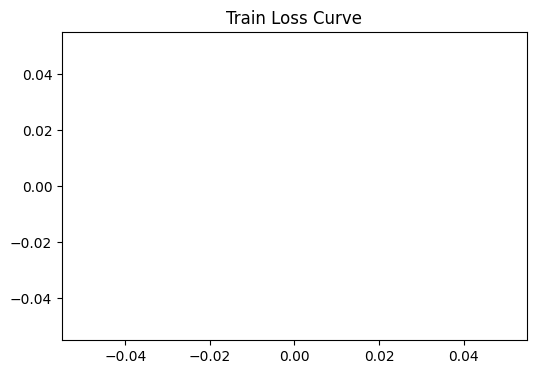

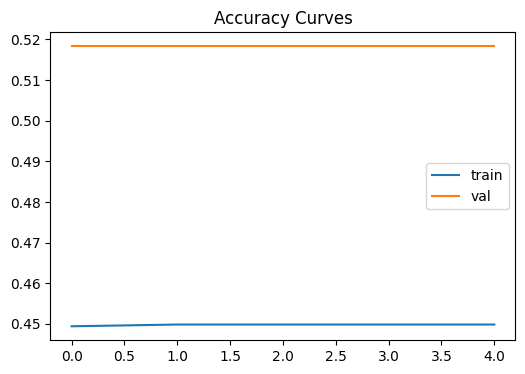

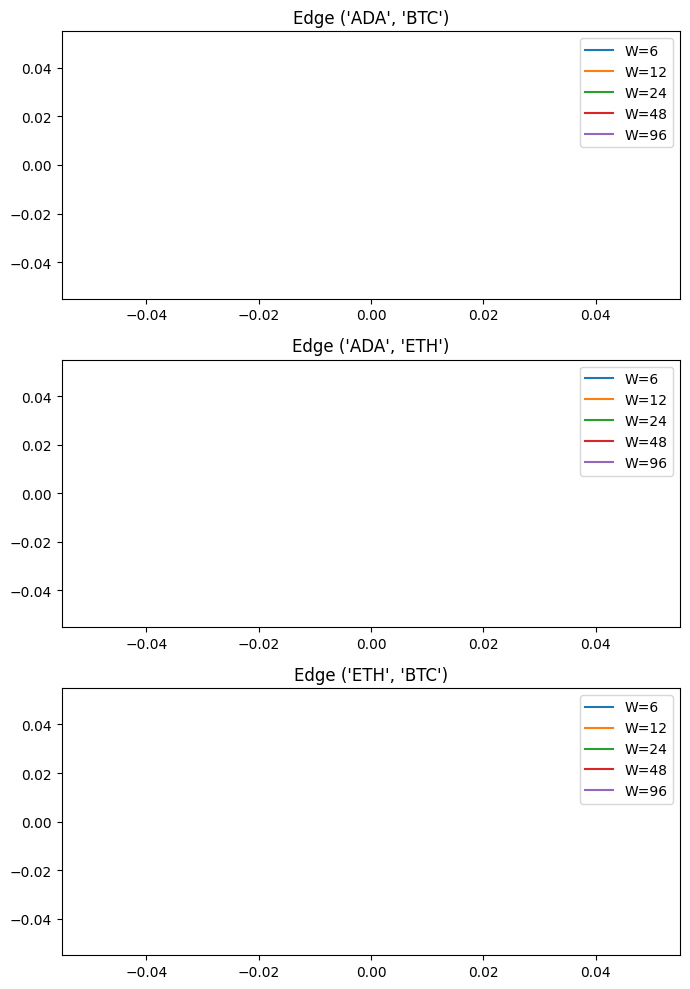

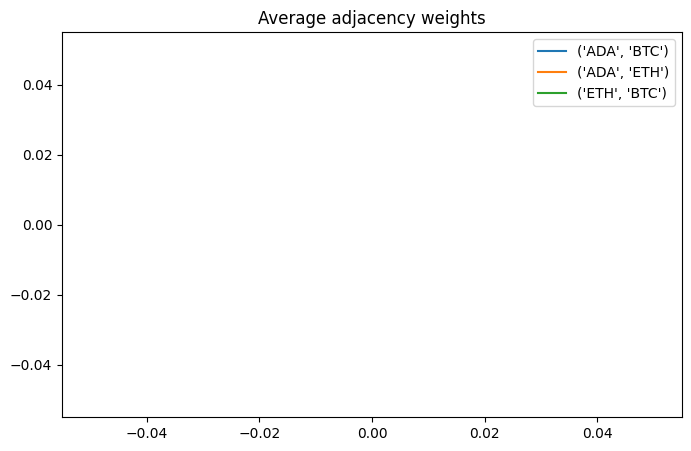

Done.


In [152]:

# ============================================================
# 9. Visualization
# ============================================================

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist)
plt.title("Train Loss Curve")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="val")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

# Attention evolution
fig, axes = plt.subplots(n_edges,1, figsize=(7,10))
for e in range(n_edges):
    for w in range(n_w):
        axes[e].plot(attn_history[:,e,w], label=f"W={candidate_windows[w]}")
    axes[e].set_title(f"Edge {edges[e]}")
    axes[e].legend()
plt.tight_layout()
plt.show()

# Average adjacency
plt.figure(figsize=(8,5))
for e in range(n_edges):
    plt.plot(avg_adj_hist[:,e], label=str(edges[e]))
plt.legend()
plt.title("Average adjacency weights")
plt.show()

print("Done.")
